# **Self Driving Related Images Classfification---From MLP To Pretrained ResNet** 

## **1. Introduction**

Over the recent decades, deep-learning has governed the main branches of areas in self-driving technology, including perception, localization, planning and control. Among these areas, perception is the first pillar of self-driving, and sensors like cameras or radars are used to capture states of the surrounding environment. In this process, object detection can be the core technology to recognize the road situation, vehicles, traffic lights, etc.

 
  
In this project, our group will focus on object detection in self-driving. To simplify the problem, we will define the problem as an image classification task with 3 labels, namely automobiles, bicycles, and pedestrians. More specifically, we will apply the MLP model as a initial solution. It can be predicted that MLP may not be efficient and effective enough for 2D image
classification. Therefore, we will subsequently optimize our solution by using CNN model and justify the advantages of CNN over MLP in this classification task. Futhermore, we will continue to explore the usage of a pretrained model, which can actually boost the speed and effectiveness of training a model.

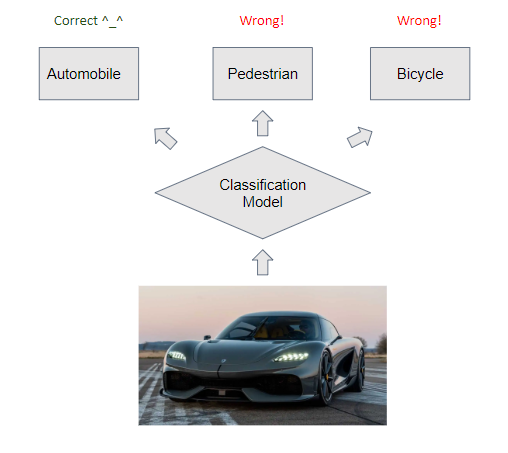

## **2. Data Collection**
In this section, we will collect pictures for the 3 categories by utilizing the Flikr Api. Since our code runs on the Google Colab, we need to firstly mount google drive.

In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    file_name = 'data_collection.ipynb'
    path_to_file = '' # Please adjust the path accordingly 
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

### **General Packages for data scraping and management:**

The code cell below imports some generally useful tools for data crawling and management. For example:
- The *requests* package allows you to send HTTP requests using Python, i.e., you can use *requests* to download files given the file link;
- The *pandas* help you store relevant information (file directory, label, etc.) in a csv or excel document;
- The *tqdm* visualizes the progress and estimated remaining time of your data processing.


In [ ]:
# Import Libraries

import os
import time
import requests
import pandas as pd
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np

from PIL import Image


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt


### **Install Python Flickr API and fetch the image links**

In [ ]:

# Flikr API key and secret (for illustration purpose only)
key = ''
secret = ''
# Inatall flickrapi
%pip install flickrapi
from flickrapi import FlickrAPI

def fetch_image_link(query):
    flickr = FlickrAPI(key, secret) #initialize python flickr api
    photos = flickr.walk(text=query,
                        tag_mode='all',
                        extras='url_c', #specify meta data to be fetched
                        sort='relevance')   #sort search result based on relevance (high to low by default)

    max_count = 3000   #let's just simply fetch 5 images for illustration
    urls = []
    count = 0

    for photo in photos:
        if count < max_count:
            count = count + 1
            #print("Fetching url for image number {}".format(count))
            try:
                url = photo.get('url_c')
                urls.append(url)
            except:
                print("Url for image number {} could not be fetched".format(count))
        else:
            print(f"Done fetching {query} urls, fetched {len(urls)} urls out of {max_count}")
            break
    return urls
    
QURIES = ['automobile', 'pedestrian','bicycle']    #specify search query
for query in QURIES:
    urls = fetch_image_link(query)
    print('example url:', urls[0])
    urls = pd.Series(urls)
    save_path = './Flickr_scrape/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    category_path = f'{save_path}/{query}_urls.csv'
    print(f"Writing {query} urls to {category_path}")
    urls.to_csv(category_path)


### **Download files using acquired links**

In [ ]:
def fetch_files_with_link(url_path):
    with open(url_path, newline="") as csvfile:
        urls = pd.read_csv(url_path, delimiter=',')
        urls = urls.iloc[:, 1].to_dict().values()
        
    SAVE_PATH = os.path.join(url_path.replace('_urls.csv', ''))
    if not os.path.isdir(SAVE_PATH):
        os.mkdir(SAVE_PATH) #define image storage path

    for idx, url in tqdm(enumerate(urls), total=len(urls)):
        # print("Starting download {} of ".format(url[0] + 1), len(urls))
        try:
            resp = requests.get(url, stream=True)   #request file using url
            path_to_write = os.path.join(SAVE_PATH, url.split("/")[-1])
            outfile = open(path_to_write, 'wb')
            outfile.write(resp.content) #save file content
            outfile.close()
            #print("Done downloading {} of {}".format(idx + 1, len(urls)))
        except:
            print("Failed to download url number {}".format(idx)) 
    print(f"Done with {url_path} download, images are saved in {SAVE_PATH}")

print("Start downloading images...")


CATEGORIES = ['automobile', 'pedestrian','bicycle']   #specify search query
save_path = './Flickr_scrape/'
for category in CATEGORIES:
    url_path = f'{save_path}/{category}_urls.csv'
    fetch_files_with_link(url_path)

### **Visualize Collected Image Data Samples**

In [ ]:
import ipywidgets as widgets
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import cv2

def plot_samples(category):
    paths = sorted(glob(f'./Flickr_scrape/pictures/{category}/*.*'))
    paths = np.random.choice(paths, 4, replace=False)

    plt.figure(figsize=(12,12))
    for i in range(4):
        image = cv2.imread(paths[i])[...,[2,1,0]]
        image = cv2.resize(image, (512,512), interpolation=cv2.INTER_LINEAR)
        plt.subplot(1, 4, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

all_categories = ['automobile', 'pedestrian','bicycle']
widgets.interact_manual.opts['manual_name'] = 'Show samples'
im = widgets.interact_manual(lambda category: plot_samples(category), category=all_categories)

interactive(children=(Dropdown(description='category', options=('automobile', 'pedestrian', 'bicycle'), value=…

## **3. Data Exploration, Pre-processing, and Analysis**

Upon acquiring our data set, we did some statistical analysis to better understand some data property. This can be helpful to data pre-processing and can guide our next move. We visualze the distribution of image size and ratio, and remove images with extreme ratios.

It can be seen that the majority of images have an area of 400000 to 500000 and a size ratio of 1 to 2. Therefore, we remove those images out of these ranges by deleting the images.

In [ ]:
import seaborn as sns

def get_size(path):
    image = cv2.imread(path)
    shape = image.shape[:2]

    return shape[1]*shape[0], shape[1]/shape[0]
  
all_species = ['automobile', 'pedestrian','bicycle']

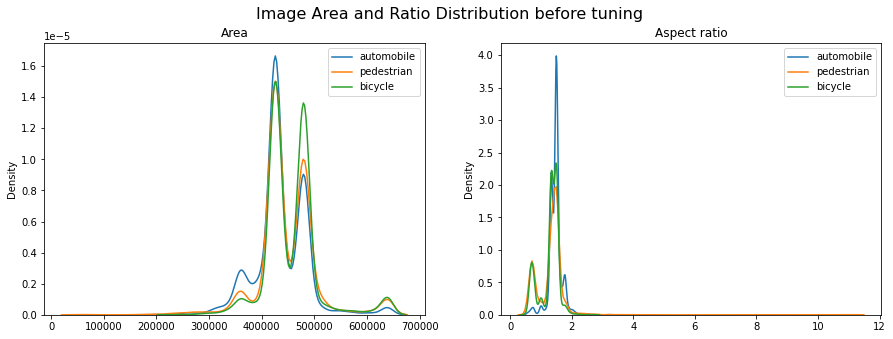

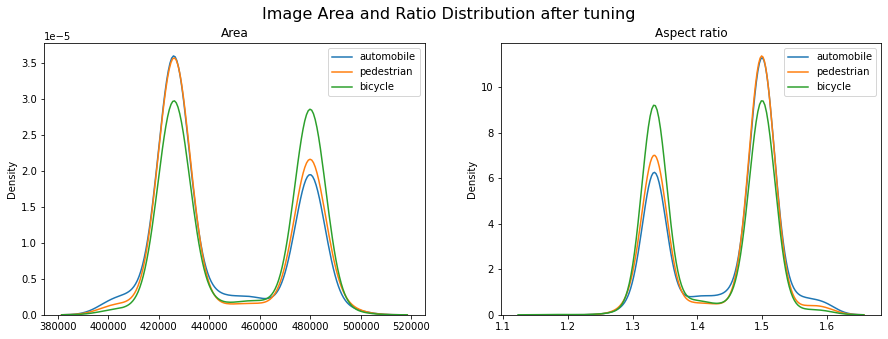

In [ ]:
# Image Area and Ratio Distribution before tuning
sizes_origin = []
ratios_origin = []
fig_origin, (ax0_origin, ax1_origin) = plt.subplots(1, 2, figsize=(15,5))
for i, species in enumerate(all_species):
    paths = sorted(glob(f'Flickr_scrape/pictures/{species}/*.*'))
    output = np.array([get_size(path) for path in paths])
      
    sizes_origin.append(output[:,0])
    ratios_origin.append(output[:,1])

    sns.kdeplot(output[:,0], label = species, ax=ax0_origin)
    sns.kdeplot(output[:,1], label = species, ax=ax1_origin)
fig_origin.suptitle('Image Area and Ratio Distribution before tuning', fontsize=16)
ax0_origin.set_title('Area')
ax1_origin.set_title('Aspect ratio')
ax0_origin.legend()
ax1_origin.legend()
plt.show()
# Image Area and Ratio Distribution after tuning
sizes_tuned = []
ratios_tuned = []
fig_tuned, (ax0_tuned, ax1_tuned) = plt.subplots(1, 2, figsize=(15,5))
for i, species in enumerate(all_species):
    paths = sorted(glob(f'Flickr_scrape/pictures/{species}/*.*'))
    output = []
    for path in paths:
      res = get_size(path)
      if res[0] >= 400000 and res[0] <= 500000 and res[1] >=1 and res[1] <= 2:
        output.append(res)
    output = np.array(output)
    
    sizes_tuned.append(output[:,0])
    ratios_tuned.append(output[:,1])

    sns.kdeplot(output[:,0], label = species, ax=ax0_tuned)
    sns.kdeplot(output[:,1], label = species, ax=ax1_tuned)
fig_tuned.suptitle('Image Area and Ratio Distribution after tuning', fontsize=16)
ax0_tuned.set_title('Area')
ax1_tuned.set_title('Aspect ratio')
ax0_tuned.legend()
ax1_tuned.legend()
plt.show()


### **Delete images with extreme ratios and areas**

In [ ]:
delete_count = 0
left_count = 0
automobile = 0
automobile_del = 0
pedestrian = 0
pedestrian_del = 0
bicycle = 0
bicycle_del = 0


for i, species in enumerate(all_species):
    paths = sorted(glob(f'Flickr_scrape/pictures/{species}/*.*'))
    output = []
    for path in paths:
      res = get_size(path)
      if res[0] < 400000 or res[0] > 500000 or res[1] < 1 and res[1] > 2:
        delete_count += 1
        if species == 'automobile':
          automobile_del += 1
        elif species == 'pedestrian':
          pedestrian_del += 1
        else:
          bicycle_del += 1
        os.remove(path)
      else:
        left_count += 1
        if species == 'automobile':
          automobile += 1
        elif species == 'pedestrian':
          pedestrian += 1
        else:
          bicycle += 1
print(f'Delete {delete_count} pictures in total.')
print(f'Delete {automobile_del} automobile pictures, {pedestrian_del} pedestrain pictures, and {bicycle_del} bicycle pictures.')
print(f'There are {automobile} automobile pictures, {pedestrian} pedestrain pictures, and {bicycle} bicycle pictures left as datapoints.')
print(f'There are {left_count} datapoints in total.')

Delete 1162 pictures in total.
Delete 438 automobile pictures, 407 pedestrain pictures, and 317 bicycle pictures.
There are 1736 automobile pictures, 1963 pedestrain pictures, and 1974 bicycle pictures left as datapoints.
There are 5673 datapoints in total.
There are 4539 training data points and 1134 testing data points.
['automobile', 'bicycle', 'pedestrian']


## **4. Model Training**

In this section, we will train the classification model by using the MLP model, CNN model and Pretrained CNN model. We will see how the evolution of the model type improves the training process and model performance. More specifically, we will compare the training accuracy, test accuracy and how fast the accuracy improves. We will also apply data augumentation methods to avoid the over-fitting problem.

### **4.1 Some Util Functions**

In [ ]:
def accuracy(y_pred, y):
  # Compute the accuracy along the rows, averaging along the number of samples
  return np.equal(y_pred,np.array(y)).mean()

def to_categorical(x, class_num):
  # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
  categorical = np.zeros((x.shape[0], class_num))
  res = np.zeros(x.shape[0])
  res[np.arange(x.shape[0])] = x.argmax(axis=1)
  return res

### **4.2 Training with MLP Model**



In [ ]:
data_dir = '/content/gdrive/My Drive/Colab/CS5242 Project/Flickr_scrape/pictures'
def load_split_train_test(datadir, valid_size = .2):

    # Specify transforms using torchvision.transforms as transforms
    # library
    transformations = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_data = datasets.ImageFolder(datadir,       
                    transform=transformations)     
    test_data = datasets.ImageFolder(datadir,
                    transform=transformations)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    print(f'There are {len(train_idx)} training data points and {len(test_idx)} testing data points.')
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=32)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=32)
    return trainloader, testloader
train_loader, val_loader = load_split_train_test(data_dir, .2)
print(f'Labels: {train_loader.dataset.classes}')

There are 4539 training data points and 1134 testing data points.
Labels: ['automobile', 'bicycle', 'pedestrian']


In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(224 * 224 * 3, 30),
      nn.Dropout(0.1), # Applying dropout to avoid over-fitting
      nn.ReLU(),
      nn.Linear(30, 10),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(10, 3),
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
# Record statistics values
train_loss_ls = []
train_acc_ls = []
test_loss_ls = []
test_acc_ls = []
start = time.time()
# Run the training loop
print(f'Start training')
print('-------------------------------------------------------')
for epoch in range(0, 20): # 20 epochs at maximum
  mlp.train()

  
  # Set current loss value
  train_loss = 0
  train_acc = 0
  test_loss = 0
  test_acc = 0
  
  # Iterate over the DataLoader for training data
  for i, data in enumerate(train_loader):
    
    # Get inputs
    inputs, targets = data
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Perform forward pass
    outputs = mlp(inputs)
    # print(outputs)
    # print(targets)
    
    # Compute loss
    loss = loss_function(outputs, targets)
    train_loss += loss.item()
    train_acc += accuracy(to_categorical(outputs, len(all_categories)), targets)
    
    # Perform backward pass
    loss.backward()
    
    # Perform optimization
    optimizer.step()

  train_loss = train_loss / len(train_loader)
  train_acc = train_acc / len(train_loader)
  # Evaluate the Model
  mlp.eval()
  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = mlp(inputs)
      loss = loss_function(outputs, labels)
      test_loss += loss.item()
      test_acc += accuracy(to_categorical(outputs, len(all_categories)), labels)
    test_loss = test_loss / len(val_loader)
    test_acc = test_acc / len(val_loader)
  train_loss_ls.append(train_loss)
  train_acc_ls.append(train_acc)
  test_loss_ls.append(test_loss)
  test_acc_ls.append(test_acc)
  print('After epoch %2d, train_loss | test_loss | train_acc | test_acc: %.3f | %.3f | %.3f | %.3f' %(epoch + 1, train_loss, test_loss, train_acc, test_acc))
# Process is complete.
tot_time = round((time.time() - start) / 60,3)
print(f'Training process has finished. Total time cost is {tot_time} mins.')
torch.save(mlp, '/content/gdrive/My Drive/Colab/CS5242 Project/MLP.pth')

Start training
-------------------------------------------------------
After epoch  1, train_loss | test_loss | train_acc | test_acc: 1.175 | 1.034 | 0.404 | 0.452
After epoch  2, train_loss | test_loss | train_acc | test_acc: 1.082 | 1.042 | 0.460 | 0.492
After epoch  3, train_loss | test_loss | train_acc | test_acc: 1.014 | 1.081 | 0.501 | 0.456
After epoch  4, train_loss | test_loss | train_acc | test_acc: 0.931 | 1.007 | 0.541 | 0.493
After epoch  5, train_loss | test_loss | train_acc | test_acc: 0.908 | 1.033 | 0.566 | 0.492
After epoch  6, train_loss | test_loss | train_acc | test_acc: 0.841 | 1.060 | 0.602 | 0.540
After epoch  7, train_loss | test_loss | train_acc | test_acc: 0.792 | 1.032 | 0.633 | 0.524
After epoch  8, train_loss | test_loss | train_acc | test_acc: 0.758 | 1.073 | 0.655 | 0.517
After epoch  9, train_loss | test_loss | train_acc | test_acc: 0.716 | 1.090 | 0.671 | 0.530
After epoch 10, train_loss | test_loss | train_acc | test_acc: 0.665 | 1.107 | 0.694 | 0.529

Text(0, 0.5, 'Accuracy')

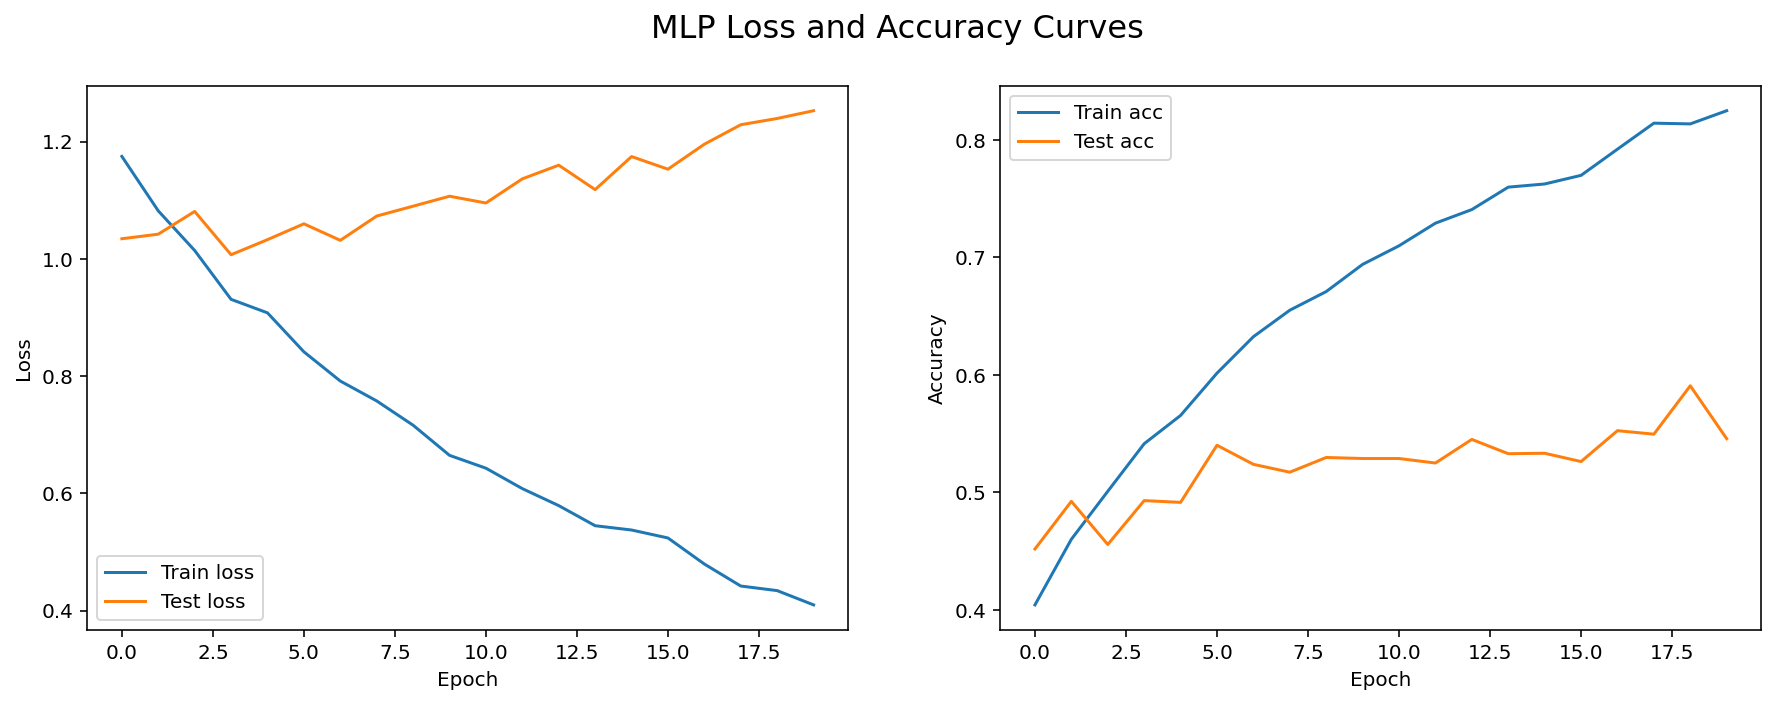

In [ ]:
# Plot the loss and accuracy curves
fig_mlp,ax_mlp = plt.subplots(1,2,figsize=(15,5))
fig_mlp.suptitle('MLP Loss and Accuracy Curves',fontsize=16)
ax_mlp[0].plot(train_loss_ls,label="Train loss")
ax_mlp[0].plot(test_loss_ls,label="Test loss")
ax_mlp[0].legend()
ax_mlp[0].set_xlabel("Epoch")
ax_mlp[0].set_ylabel("Loss")

ax_mlp[1].plot(train_acc_ls,label="Train acc")
ax_mlp[1].plot(test_acc_ls,label="Test acc")
ax_mlp[1].legend()
ax_mlp[1].set_xlabel("Epoch")
ax_mlp[1].set_ylabel("Accuracy")

It can be seen from the plot and the log that the maximum test accuracy that the model can obtain is around 55%, which is relatively low. Even we attempted to apply dropout and simplify the model structure, the over-fitting problem cannot be futher improved. 

### **4.3 Train with Generic CNN**

In [ ]:
data_dir = '/content/gdrive/My Drive/Colab/CS5242 Project/Flickr_scrape/pictures'
def load_split_train_test(datadir, valid_size = .2):

    # Specify transforms using torchvision.transforms as transforms
    # library
    transformations = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30, resample=False, expand=False, center=None),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_data = datasets.ImageFolder(datadir,       
                    transform=transformations)     
    test_data = datasets.ImageFolder(datadir,
                    transform=transformations)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    print(f'There are {len(train_idx)} training data points and {len(test_idx)} testing data points.')
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=32)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=32)
    return trainloader, testloader
train_loader, val_loader = load_split_train_test(data_dir, .2)
# Get CNN model using torchvision.models as models library
model = models.resnet50(pretrained=False)
num_labels = 3 #PUT IN THE NUMBER OF LABELS IN YOUR DATA
model.fc = nn.Sequential(nn.Linear(2048, 1024),
              nn.ReLU(),
              nn.Dropout(0.1),
              nn.Linear(1024, 512),
              nn.ReLU(),
              nn.Dropout(0.1),
              nn.Linear(512, num_labels))
# Find the device available to use using torch library
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the device specified above
model.to(device)
# Set the error function using torch.nn as nn library
criterion = nn.CrossEntropyLoss()
# Set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10
train_loss_ls = []
train_acc_ls = []
test_loss_ls = []
test_acc_ls = []
start = time.time()
# Run the training loop
print(f'Start training')
print('-------------------------------------------------------')
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    train_acc = 0
    val_acc = 0
    # Training the model
    model.train()

    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # Loss
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Caclulate loss and accuracy
        step_loss = loss.item()
        step_acc = accuracy(to_categorical(output.cpu(), len(all_categories)), labels.cpu())
        train_loss += step_loss
        train_acc += step_acc
        
    # Evaluating the model
    model.eval()

    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Caclulate loss and accuracy
            step_loss = valloss.item()
            step_acc = accuracy(to_categorical(output.cpu(), len(all_categories)), labels.cpu())
            val_loss += step_loss
            val_acc += step_acc
            
    
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    val_loss = val_loss/len(val_loader.dataset)
    train_acc = train_acc/len(train_loader)
    val_acc = val_acc/len(val_loader)

    train_loss_ls.append(train_loss)
    train_acc_ls.append(train_acc)
    test_loss_ls.append(val_loss)
    test_acc_ls.append(val_acc)
    # Print out the result
    print('After epoch %2d, train_loss | test_loss | train_acc | test_acc: %.3f | %.3f | %.3f | %.3f' %(epoch + 1, train_loss, val_loss, train_acc, val_acc))
tot_time = round((time.time() - start) / 60,3)
print(f'Training process has finished. Total time cost is {tot_time} mins.')
torch.save(model, '/content/gdrive/My Drive/Colab/CS5242 Project/Generic_CNN.pth')






There are 4539 training data points and 1134 testing data points.
Start training
-------------------------------------------------------
After epoch  1, train_loss | test_loss | train_acc | test_acc: 0.053 | 0.035 | 0.359 | 0.373
After epoch  2, train_loss | test_loss | train_acc | test_acc: 0.027 | 0.034 | 0.409 | 0.397
After epoch  3, train_loss | test_loss | train_acc | test_acc: 0.026 | 0.035 | 0.465 | 0.360
After epoch  4, train_loss | test_loss | train_acc | test_acc: 0.024 | 0.030 | 0.540 | 0.536
After epoch  5, train_loss | test_loss | train_acc | test_acc: 0.024 | 0.030 | 0.528 | 0.534
After epoch  6, train_loss | test_loss | train_acc | test_acc: 0.022 | 0.026 | 0.585 | 0.623
After epoch  7, train_loss | test_loss | train_acc | test_acc: 0.021 | 0.031 | 0.628 | 0.535
After epoch  8, train_loss | test_loss | train_acc | test_acc: 0.020 | 0.030 | 0.645 | 0.556
After epoch  9, train_loss | test_loss | train_acc | test_acc: 0.020 | 0.028 | 0.650 | 0.585
After epoch  10, train_los

Text(0, 0.5, 'Accuracy')

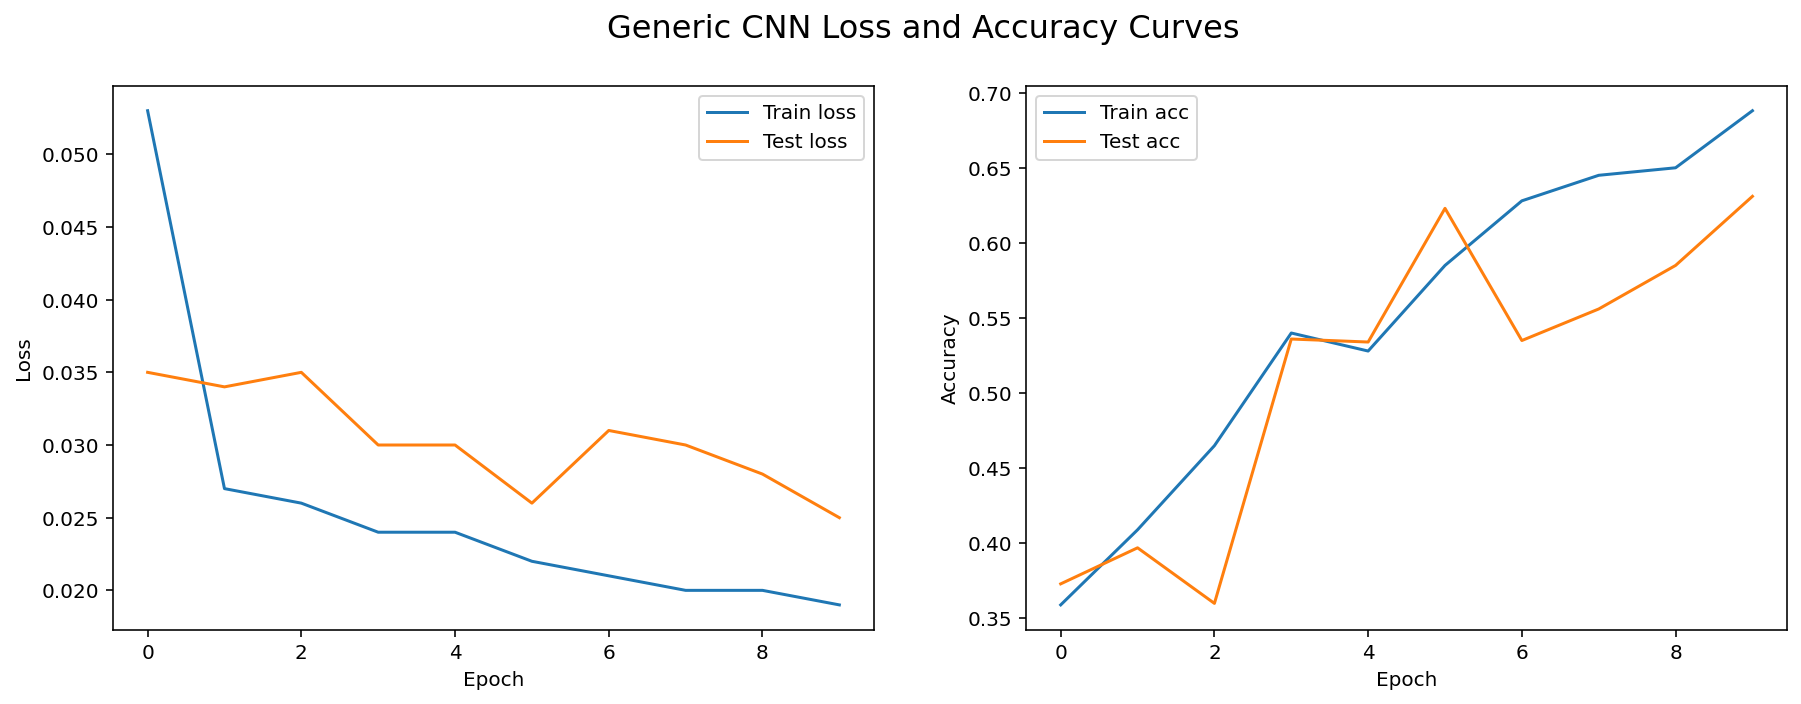

In [ ]:
# Plot the loss and accuracy curves
fig_cnn,ax_cnn = plt.subplots(1,2,figsize=(15,5))
fig_cnn.suptitle('Generic CNN Loss and Accuracy Curves',fontsize=16)
ax_cnn[0].plot(train_loss_ls,label="Train loss")
ax_cnn[0].plot(test_loss_ls,label="Test loss")
ax_cnn[0].legend()
ax_cnn[0].set_xlabel("Epoch")
ax_cnn[0].set_ylabel("Loss")

ax_cnn[1].plot(train_acc_ls,label="Train acc")
ax_cnn[1].plot(test_acc_ls,label="Test acc")
ax_cnn[1].legend()
ax_cnn[1].set_xlabel("Epoch")
ax_cnn[1].set_ylabel("Accuracy")

It can be proved from the result that the CNN model has a better validation accuracy than MLP model. This can be attributed to the invariance of a CNN model. However, it takes many iterations and much time to actually train a CNN model from a raw model. Therefore, we introduce a pretrained model, which freezes the Conv layers and only train FC layers of a Resnet50 network.

### **4.4 Pretrained CNN Model**

In [ ]:
# Get pretrained model using torchvision.models as models library
model_pretrained = models.resnet50(pretrained=True)
# Turn off training for their parameters
for param in model_pretrained.parameters():
    param.requires_grad = False
# Set the error function using torch.nn as nn library
criterion = criterion = nn.CrossEntropyLoss()
num_labels = 3 #PUT IN THE NUMBER OF LABELS IN YOUR DATA
model_pretrained.fc = nn.Sequential(nn.Linear(2048, 1024),
                  nn.ReLU(),
                  nn.Dropout(0.2),
                  nn.Linear(1024, 512),
                  nn.ReLU(),
                  nn.Dropout(0.2),
                  nn.Linear(512, num_labels))
# Set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model_pretrained.fc.parameters(), lr=0.003)
# Find the device available to use using torch library
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model_pretrained to the device specified above
model_pretrained.to(device)
epochs = 10
train_loss_ls = []
train_acc_ls = []
test_loss_ls = []
test_acc_ls = []
start = time.time()
# Run the training loop
print(f'Start training')
print('-------------------------------------------------------')
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    train_acc = 0
    val_acc = 0
    
    # Training the model_pretrained
    model_pretrained.train()
    # counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model_pretrained.forward(inputs)
        # Loss
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Caclulate loss and accuracy
        step_loss = loss.item()
        step_acc = accuracy(to_categorical(output.cpu(), len(all_categories)), labels.cpu())
        train_loss += step_loss
        train_acc += step_acc
        
    # Evaluating the model_pretrained
    model_pretrained.eval()
    # counter = 0
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            output = model_pretrained.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Caclulate loss and accuracy
            step_loss = valloss.item()
            step_acc = accuracy(to_categorical(output.cpu(), len(all_categories)), labels.cpu())
            val_loss += step_loss
            val_acc += step_acc
    
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    val_loss = val_loss/len(val_loader.dataset)
    train_acc = train_acc/len(train_loader)
    val_acc = val_acc/len(val_loader)

    train_loss_ls.append(train_loss)
    train_acc_ls.append(train_acc)
    test_loss_ls.append(val_loss)
    test_acc_ls.append(val_acc)
    # Print out the result
    print('After epoch %2d, train_loss | test_loss | train_acc | test_acc: %.3f | %.3f | %.3f | %.3f' %(epoch + 1, train_loss, val_loss, train_acc, val_acc))
tot_time = round((time.time() - start) / 60,3)
print(f'Training process has finished. Total time cost is {tot_time} mins.')
torch.save(model_pretrained, '/content/gdrive/My Drive/Colab/CS5242 Project/Pretrained_CNN.pth')


There are 4539 training data points and 1134 testing data points.
Start training
-------------------------------------------------------
After epoch  1, train_loss | test_loss | train_acc | test_acc: 9.53e-5 | 7.05e-5 | 0.823 | 0.836
After epoch  2, train_loss | test_loss | train_acc | test_acc: 5.62e-5 | 3.00e-5 | 0.886 | 0.900
After epoch  3, train_loss | test_loss | train_acc | test_acc: 4.65e-5 | 3.09e-5 | 0.912 | 0.889
After epoch  4, train_loss | test_loss | train_acc | test_acc: 4.71e-5 | 2.65e-5 | 0.910 | 0.904
After epoch  5, train_loss | test_loss | train_acc | test_acc: 4.18e-5 | 2.65e-5 | 0.917 | 0.910
After epoch  6, train_loss | test_loss | train_acc | test_acc: 4.42e-5 | 2.29e-5 | 0.920 | 0.932
After epoch  7, train_loss | test_loss | train_acc | test_acc: 4.42e-5 | 2.73e-5 | 0.913 | 0.947
After epoch  8, train_loss | test_loss | train_acc | test_acc: 4.19e-5 | 2.65e-5 | 0.917 | 0.906
After epoch  9, train_loss | test_loss | train_acc | test_acc: 3.99e-5 | 2.47e-5 | 0.92

Text(0, 0.5, 'Accuracy')

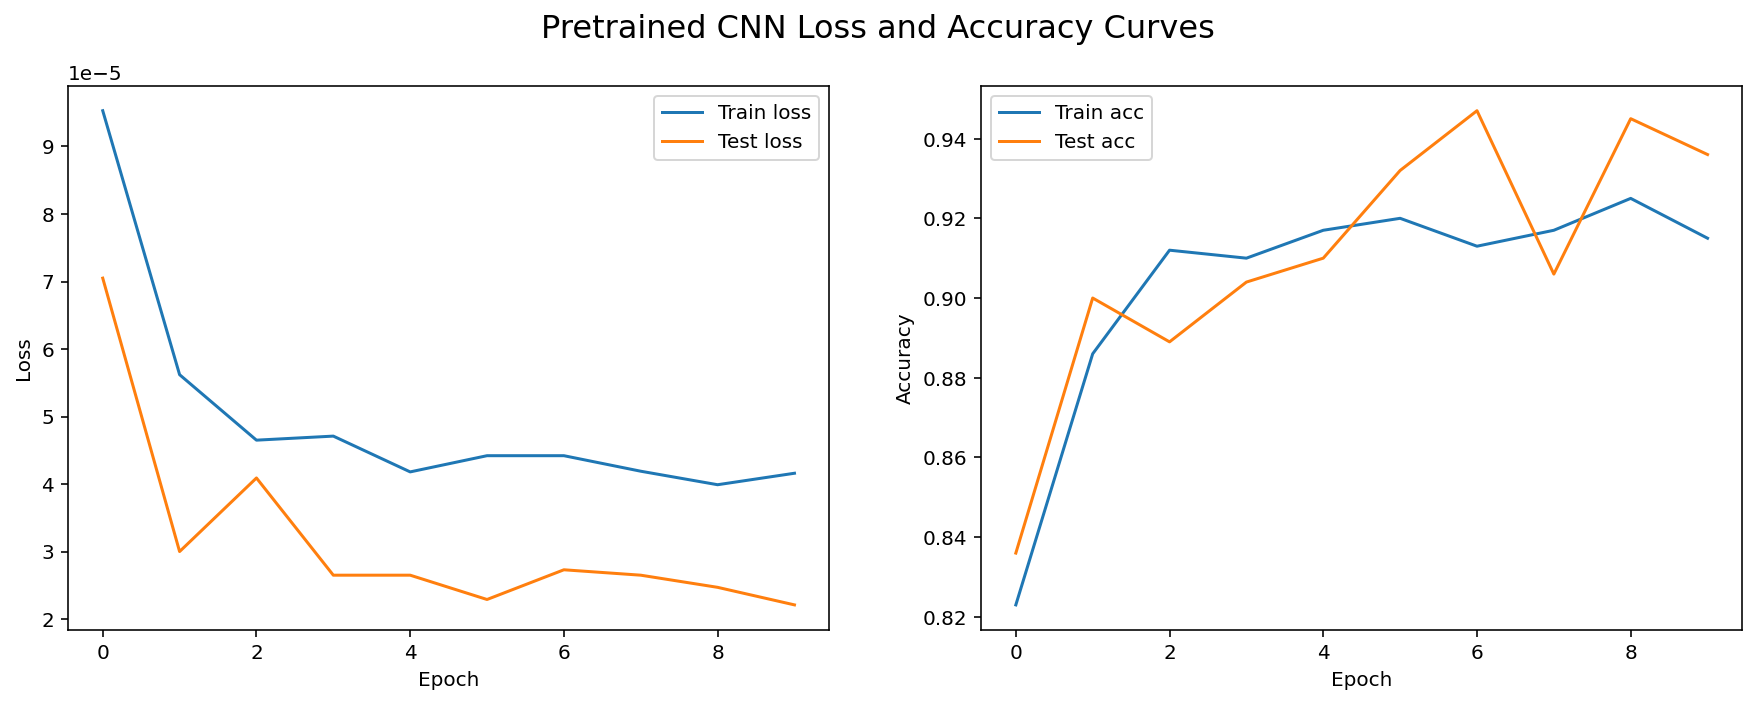

In [ ]:
# Plot the loss and accuracy curves
fig_cnn,ax_cnn = plt.subplots(1,2,figsize=(15,5))
fig_cnn.suptitle('Pretrained CNN Loss and Accuracy Curves',fontsize=16)
ax_cnn[0].plot(train_loss_ls,label="Train loss")
ax_cnn[0].plot(test_loss_ls,label="Test loss")
ax_cnn[0].legend()
ax_cnn[0].set_xlabel("Epoch")
ax_cnn[0].set_ylabel("Loss")

ax_cnn[1].plot(train_acc_ls,label="Train acc")
ax_cnn[1].plot(test_acc_ls,label="Test acc")
ax_cnn[1].legend()
ax_cnn[1].set_xlabel("Epoch")
ax_cnn[1].set_ylabel("Accuracy")

Compared to a generic CNN model, a pretrained CNN is trained much faster, with an accuracy over 90% starting from the 3rd epoch. The maximum test accuracy is around 94% and the maximum train accuracy is around 92%.

## **5. Our Findings and Thoughts**


* MLP has a low accuracy. And it can be deduced that it is maybe because MLP does not have a translation or rotational invariance.

* Unpretrained ResNet has a higher accuracy limit than MLP. However, it takes too many epochs to train it without pretrained CNN layers. Within 10 epochs, the max training accuracy and the max test accuracy are no more than 70 %, which is relatively slow. We can see that unpretrained ResNet performs badly on a such small dataset, also it is time-consuming.

* The pretrained CNN model shows a very satisfying result. Within 10 epochs, both training accuracy and test accuracy reach more than 90% and are almost converged. It shows the power of transfer learning on such a small dataset in computer vision tasks.